This notebook performs all post-processing of allelic data that is included in the paper regarding scRNA-seq allelic kinetics of XCR (not XCU)  

The input data is the matrix generated by Bart in notebooks: Adrian_Allele_specific_preproc and Adrian_allele_specific_analysis_zeros_included_norm  
  
Here, I will import the final matrix with normalized allelic ratios

In [1]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/")

In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(readr)
    library(ggplot2)
    library(tidyr)
    library(tibble)
    suppressMessages(library(viridis))
})

Warning message:
"package 'Seurat' was built under R version 3.6.2"

In [3]:
allelic <- read_csv("allele_specific/pre_processing/AJ_0065.9c_allelic_norm_complete.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_double(),
  gene = col_character(),
  RNA_id = col_character(),
  X = col_double(),
  X129 = col_double(),
  Cast = col_double(),
  sumReads = col_double(),
  ratioPercent = col_double(),
  ratioLog = col_double(),
  Pseudotime = col_double(),
  seurat_clusters_rename = col_double(),
  Timepoint = col_character(),
  Xi = col_character(),
  Chr = col_character(),
  total_reads = col_double(),
  mus_norm = col_double(),
  cast_norm = col_double(),
  ratio_norm = col_double(),
  sum_norm = col_double()
)


In [5]:
allelic <- allelic %>% 
                rename("cluster_replace" = "seurat_clusters_rename")

In [6]:
# For later create a mapping table of RNA_id:cell_type:cluster_replace

mapping <- allelic %>%
                select(RNA_id, cluster_replace) %>%
                group_by(RNA_id) %>%
                distinct()

consistent_cluster <- allelic %>% filter(sumReads > 10, Chr == "chrX") %>%
                                group_by(cluster_replace, gene) %>%
                                distinct(gene) %>%
                                ungroup() %>%
                                count(gene) %>%
                                filter(n >= 6) %>%
                                select(gene)

In [8]:
genes_kinetics <- read_csv2("allele_specific/XCR/AJ_31_genes_by_kinetics.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  Escapees = col_character(),
  Early = col_character(),
  Intermediate = col_character(),
  Late = col_character(),
  `Very late` = col_character()
)


In [9]:
kinetics <- genes_kinetics %>% gather(kinetic, gene)
kinetics$kinetic <- factor(kinetics$kinetic, levels = c('Early','Intermediate','Late','Very late' , 'Escapees'))

In [10]:
allelic_kin <- merge(allelic, kinetics, by="gene")

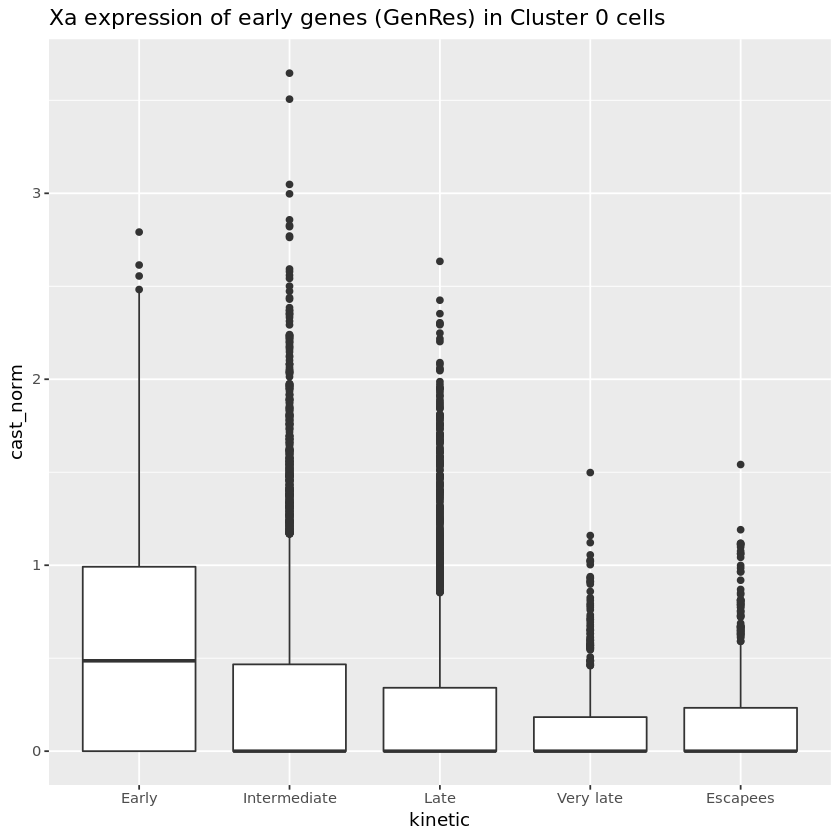

In [11]:
allelic_kin %>% 
    filter(Chr == "chrX", cluster_replace == 0) %>%
        ggplot(aes(kinetic, cast_norm)) +
            geom_boxplot()+
            ggtitle("Xa expression of early genes (GenRes) in Cluster 0 cells")

In [9]:
chrX <- allelic_kin %>% filter(Chr=="chrX" & sumReads >= 1) %>% select(gene,RNA_id,mus_norm,cast_norm,cluster_replace, ratio_norm, kinetic) %>% 
        group_by(cluster_replace, RNA_id, kinetic) %>%
        summarize(mean_ratio = mean(ratio_norm))

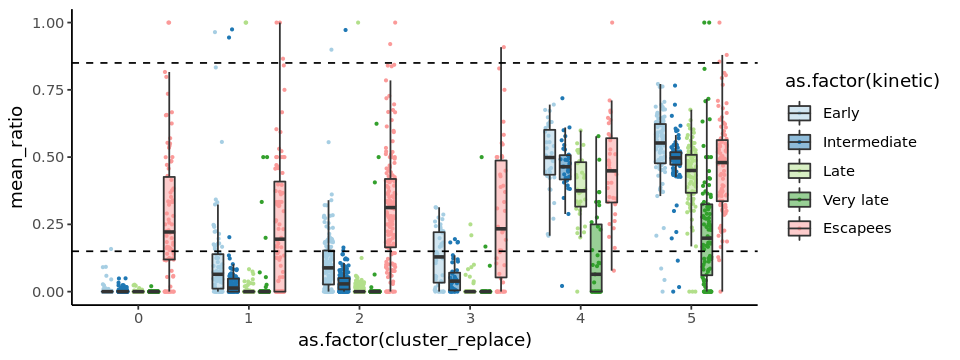

In [10]:
options(repr.plot.width=8, repr.plot.height=3)
kinetics_plot <- ggplot(chrX, aes(as.factor(cluster_replace), mean_ratio)) +
                                                     geom_point(aes(color = as.factor(kinetic)),
                                                                  position = position_jitterdodge(jitter.width = .3, dodge.width=.7),
                                                                  size = .5) +
                                                     geom_boxplot(aes(fill = as.factor(kinetic)), 
                                                                  outlier.colour = NA, 
                                                                  position=position_dodge(0.7),
                                                                  width = .5,
                                                                  alpha = .5)+
                                                     geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                #     coord_cartesian(ylim = c(0,1))+
                                                     scale_color_brewer(palette = "Paired")+
                                                     scale_fill_brewer(palette = "Paired")+
                                                     # coord_flip()+

                                                        theme_classic() 
kinetics_plot                                            

In [31]:
#setwd("/ddn1/vol1/staging/leuven/stg_00041/Bart/Exp2/Data/RNA/Figures")
#pdf(paste0("Adrian_kinetics_after_normalisation.pdf"), useDingbats = FALSE, height=5, width=10)
#kinetics_plot
#dev.off()

png 
  2

### Plotting along pseudotime

In [11]:
plot_subsetAlongPseudo <- function(data, subset){
    plot <- allelic %>% 
        filter(gene %in% consistent_cluster$gene, gene %in% subset) %>% 
        group_by(X129, Cast, sumReads, RNA_id, Pseudotime, cluster_replace) %>% 
        summarize(mean_mus = mean(mus_norm), mean_cast = mean(cast_norm) , meanX = mean(ratio_norm)) %>%                         
            ggplot(aes(Pseudotime, log2(meanX))) +
                geom_point(size = 1, alpha = 1, aes(color = cluster_replace)) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                    # coord_cartesian(ylim = c(0,1))+
                ggtitle(paste0(subset)) + 
                theme_classic()   
                                return(plot)
                                        }

In [12]:
kin <- colnames(genes_kinetics)
plots <- list()
for(i in 1:length(kin)){
subset <- genes_kinetics %>% select(i)
plots[[i]] <- allelic_kin %>% 
        filter(gene %in% consistent_cluster$gene, kinetic == kin[i] & sumReads >= 1) %>% 
        group_by(RNA_id, Pseudotime, cluster_replace) %>% 
        summarize(mean_mus = mean(mus_norm), mean_cast = mean(cast_norm) , mean_ratio = mean(ratio_norm)) %>%                         
            ggplot(aes(Pseudotime, mean_ratio)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
                ggtitle(paste0(kin[i], ", cells: ")) +
                theme_classic()   
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


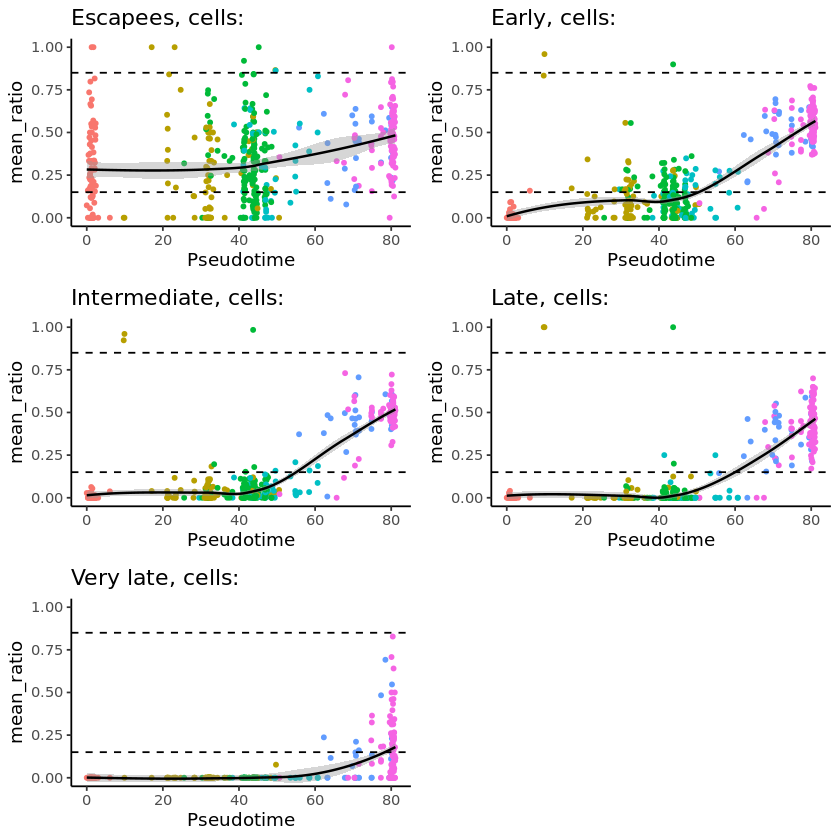

In [13]:
options(repr.plot.width=7, repr.plot.height=7)
CombinePlots(plots = plots, ncol=2, legend="none")

## Cluster genes based on the ratio modelled along the pseudotime and make a heatmap

## To do

0) Plot all genes with loess fitting and se individually (checking if spanning works for all genes and to show underlying data in supplements)  
1) Generate a loess model for a gene  
2) for each pseudotime unit 1,2,3...80 (or more densely) measure the y intercept and store in df  
3) Repeat for all genes  
4) Combine dfs  
5) Cluster with k-means   
6) Heatmap  


In [22]:
allelic %>% head()

X1,gene,RNA_id,X,X129,Cast,sumReads,ratioPercent,ratioLog,Pseudotime,...,Xi,X2,cluster,cluster_replace,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm
1,0610009B22Rik,Day_10_Xi_Mus_59,2323152,0,0,0,NA,NA,43.62880,...,Mus,226,0,2,chr11,88329,0.00000000,0.0000000,NA,0.0000000
2,0610009B22Rik,Day_10_Xi_Mus_15,1559376,0,0,0,NA,NA,48.75234,...,Mus,58,4,3,chr11,10125,0.00000000,0.0000000,NA,0.0000000
3,0610009B22Rik,Day_10_Xi_Mus_55,2259504,0,4,4,0.0001,-13.287712,44.71111,...,Mus,222,0,2,chr11,115942,0.00000000,0.2963941,0.0000000,0.2963941
4,0610009B22Rik,Day_12_Xi_Mus_85,5823792,1,7,8,0.1251,-2.806345,32.38629,...,Mus,397,1,1,chr11,142685,0.06773757,0.3991728,0.1450762,0.4669104
5,0610009B22Rik,Day_12_Xi_Mus_87,5855616,0,0,0,NA,NA,79.94168,...,Mus,391,5,4,chr11,202247,0.00000000,0.0000000,NA,0.0000000
6,0610009B22Rik,Day_9_Xi_Mus_26,7765056,4,0,4,1.0001,Inf,46.96879,...,Mus,11,0,2,chr11,181032,0.19963368,0.0000000,1.0000000,0.1996337


#### 0) Plot all genes with loess fitting and se individually (checking if spanning works for all genes and to show underlying data in supplements)

In [98]:
plots <- list()

genes <- consistent_cluster$gene

for(i in seq(genes)){

plots[[i]] <- allelic %>% 
        filter(gene == genes[i]) %>%                   
            ggplot(aes(Pseudotime, ratio_norm)) +
                geom_point(size = 1, alpha = 1, aes(color = as.factor(cluster_replace))) +
                geom_smooth(color = "black", size = .7) +                                                     
                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                     coord_cartesian(ylim = c(0,1))+
                ggtitle(paste0(genes[i])) +
                theme_classic()   +
                theme(legend.position = "none") 
}


plots <- CombinePlots(plots = plots, ncol=4)

In [100]:
pdf("AJ_0065.9_Cluster_consist_genes_loess_all.pdf", width=13, height=50)
plot(plots)
dev.off()

png 
  2

#### Set up modelling example

Warning message:
"Removed 85 rows containing non-finite values (stat_smooth)."

X1,gene,RNA_id,X,X129,Cast,sumReads,ratioPercent,ratioLog,Pseudotime,...,cluster_replace,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm,.fitted,.se.fit,.resid
5982556,Sat1,Day_12_Xi_Mus_69,5549511,0,30,30,0.0001000,-13.2877124,33.1709944,...,1,chrX,71416,0.0000000,1.6488008,0.0000000,1.6488008,0.23269768,0.02741166,-0.23269768
5982558,Sat1,Day_10_Xi_Mus_12,1523775,0,105,105,0.0001000,-13.2877124,31.3767981,...,1,chrX,153050,0.0000000,2.0618506,0.0000000,2.0618506,0.22823037,0.02993108,-0.22823037
5982560,Sat1,Day_10_Xi_Mus_43,2064783,0,16,16,0.0001000,-13.2877124,30.3503100,...,2,chrX,74480,0.0000000,1.1468397,0.0000000,1.1468397,0.22581295,0.03078945,-0.22581295
5982562,Sat1,Day_0_Xi_Mus_75,1110063,0,11,11,0.0001000,-13.2877124,0.8525002,...,0,chrX,111172,0.0000000,0.6878621,0.0000000,0.6878621,0.01129669,0.03349246,-0.01129669
5982564,Sat1,Day_12_Xi_Mus_56,5326743,11,0,11,1.0001000,Inf,67.8072883,...,4,chrX,74653,0.9056277,0.0000000,1.0000000,0.9056277,0.55189461,0.04258973,0.44810539
5982566,Sat1,Day_8_Xi_Mus_18,6170079,6,8,14,0.4286714,-0.4148452,31.9402983,...,1,chrX,57698,0.7128995,0.8698404,0.4504211,1.5827399,0.22958492,0.02936208,0.22083623


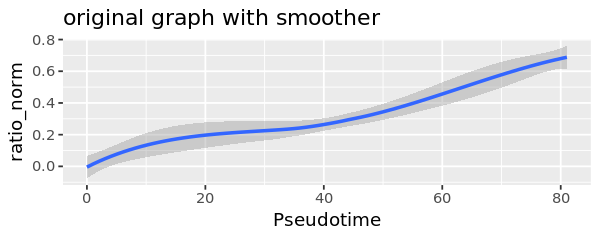

gene,pseudotime,fitted_data
Sat1,0,-0.004631993
Sat1,1,0.013971104
Sat1,2,0.031183233
Sat1,3,0.047244262
Sat1,4,0.062293539
Sat1,5,0.076369694


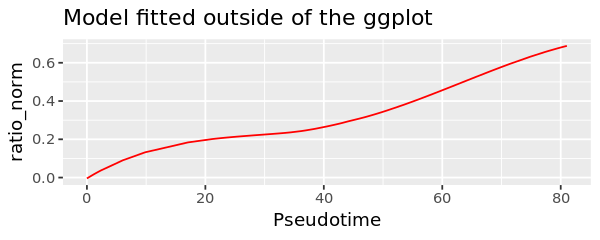

In [21]:
options(repr.plot.width=5, repr.plot.height=2)

#library(tidyverse)
library(broom)

# Subset dataset
test <- allelic %>% filter(gene == "Sat1")

# original graph with smoother
ggplot(data=test, aes(Pseudotime,ratio_norm)) + 
  geom_smooth(method = "loess")+
    ggtitle("original graph with smoother")

# Create model that will do the same thing as under the hood in ggplot2
model <- loess(ratio_norm ~ Pseudotime, data = test, span = 0.75)

# Add predicted values from model to original dataset using broom library
test2 <- augment(model, test)
test2 %>% head()

# Plot the fit of the model generated outside ggplot

ggplot(data=test2, aes(Pseudotime,ratio_norm)) + 
  geom_line(aes(Pseudotime, .fitted), color = "red") +
  #stat_smooth(method = "loess", span = 0.75) +
    ggtitle("Model fitted outside of the ggplot")

# Predict for a complete range of new data points
# This way for all genes I will the same, complete, set of values that I can do k-means on and the heatmap

new_data <- predict(model, newdata = 0:80, se = TRUE)
new_data <- data.frame(gene = rep("Sat1"), pseudotime = 0:80, fitted_data = new_data$fit)
head(new_data)

#### Expand the fitting to all genes at once

In [22]:
# Wrap fitting and adding model to the input df in a single function

fit_n_add <- function(data, y, x, gene, range, span = 0.75){
    
    # Create model that will do the same thing as under the hood in ggplot2
        model <- loess(y ~ x, data = data, span = span)

    # Add predicted values from model to original dataset using broom library
        # This is not going to be used, but might be useful other time
        # df <- augment(model, data)
    
    # Create a new data frame which links gene and fitted norm_ratio value for the pseudotime range of 0:80
    
    predicted <- predict(model, newdata = range, se = TRUE)
    
    df <- data.frame(gene = gene, pseudotime = range, fitted_data = predicted$fit)
    
    return(df)
}

In [25]:
# Calculate fitted lines for all cluster consistent X-linked genes

library(purrr)

allelic_fit_chrX_clust_cons <- allelic %>% filter(gene %in% consistent_cluster$gene) %>%
                                group_split(gene) %>%
                                map(~fit_n_add(data = .,
                                               y = .$ratio_norm,
                                               x = .$Pseudotime,
                                               gene = .$gene[1],
                                               range = 2:80)) %>%
                                bind_rows() 

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding cha

In [26]:
# K-means clustering based on fitted trends

allelic_fit_chrX_clust_cons_mtx <- allelic_fit_chrX_clust_cons %>% 
                filter(gene != "Xist") %>% 
                spread(pseudotime, fitted_data) %>% 
                column_to_rownames("gene")

# Compute k-means with k = 6
set.seed(123)
km.res.fit <- kmeans(allelic_fit_chrX_clust_cons_mtx, 5,iter.max = 100, nstart = 100)

allelic_fit_kmeans <- cbind(allelic_fit_chrX_clust_cons_mtx, k_means_cluster = km.res.fit$cluster) %>% 
                                as.data.frame() %>%
                                rownames_to_column("gene")

allelic_fit_kmeans_long <- allelic_fit_kmeans %>%
                                    gather(pseudotime, fitted_data,-gene, -k_means_cluster) 

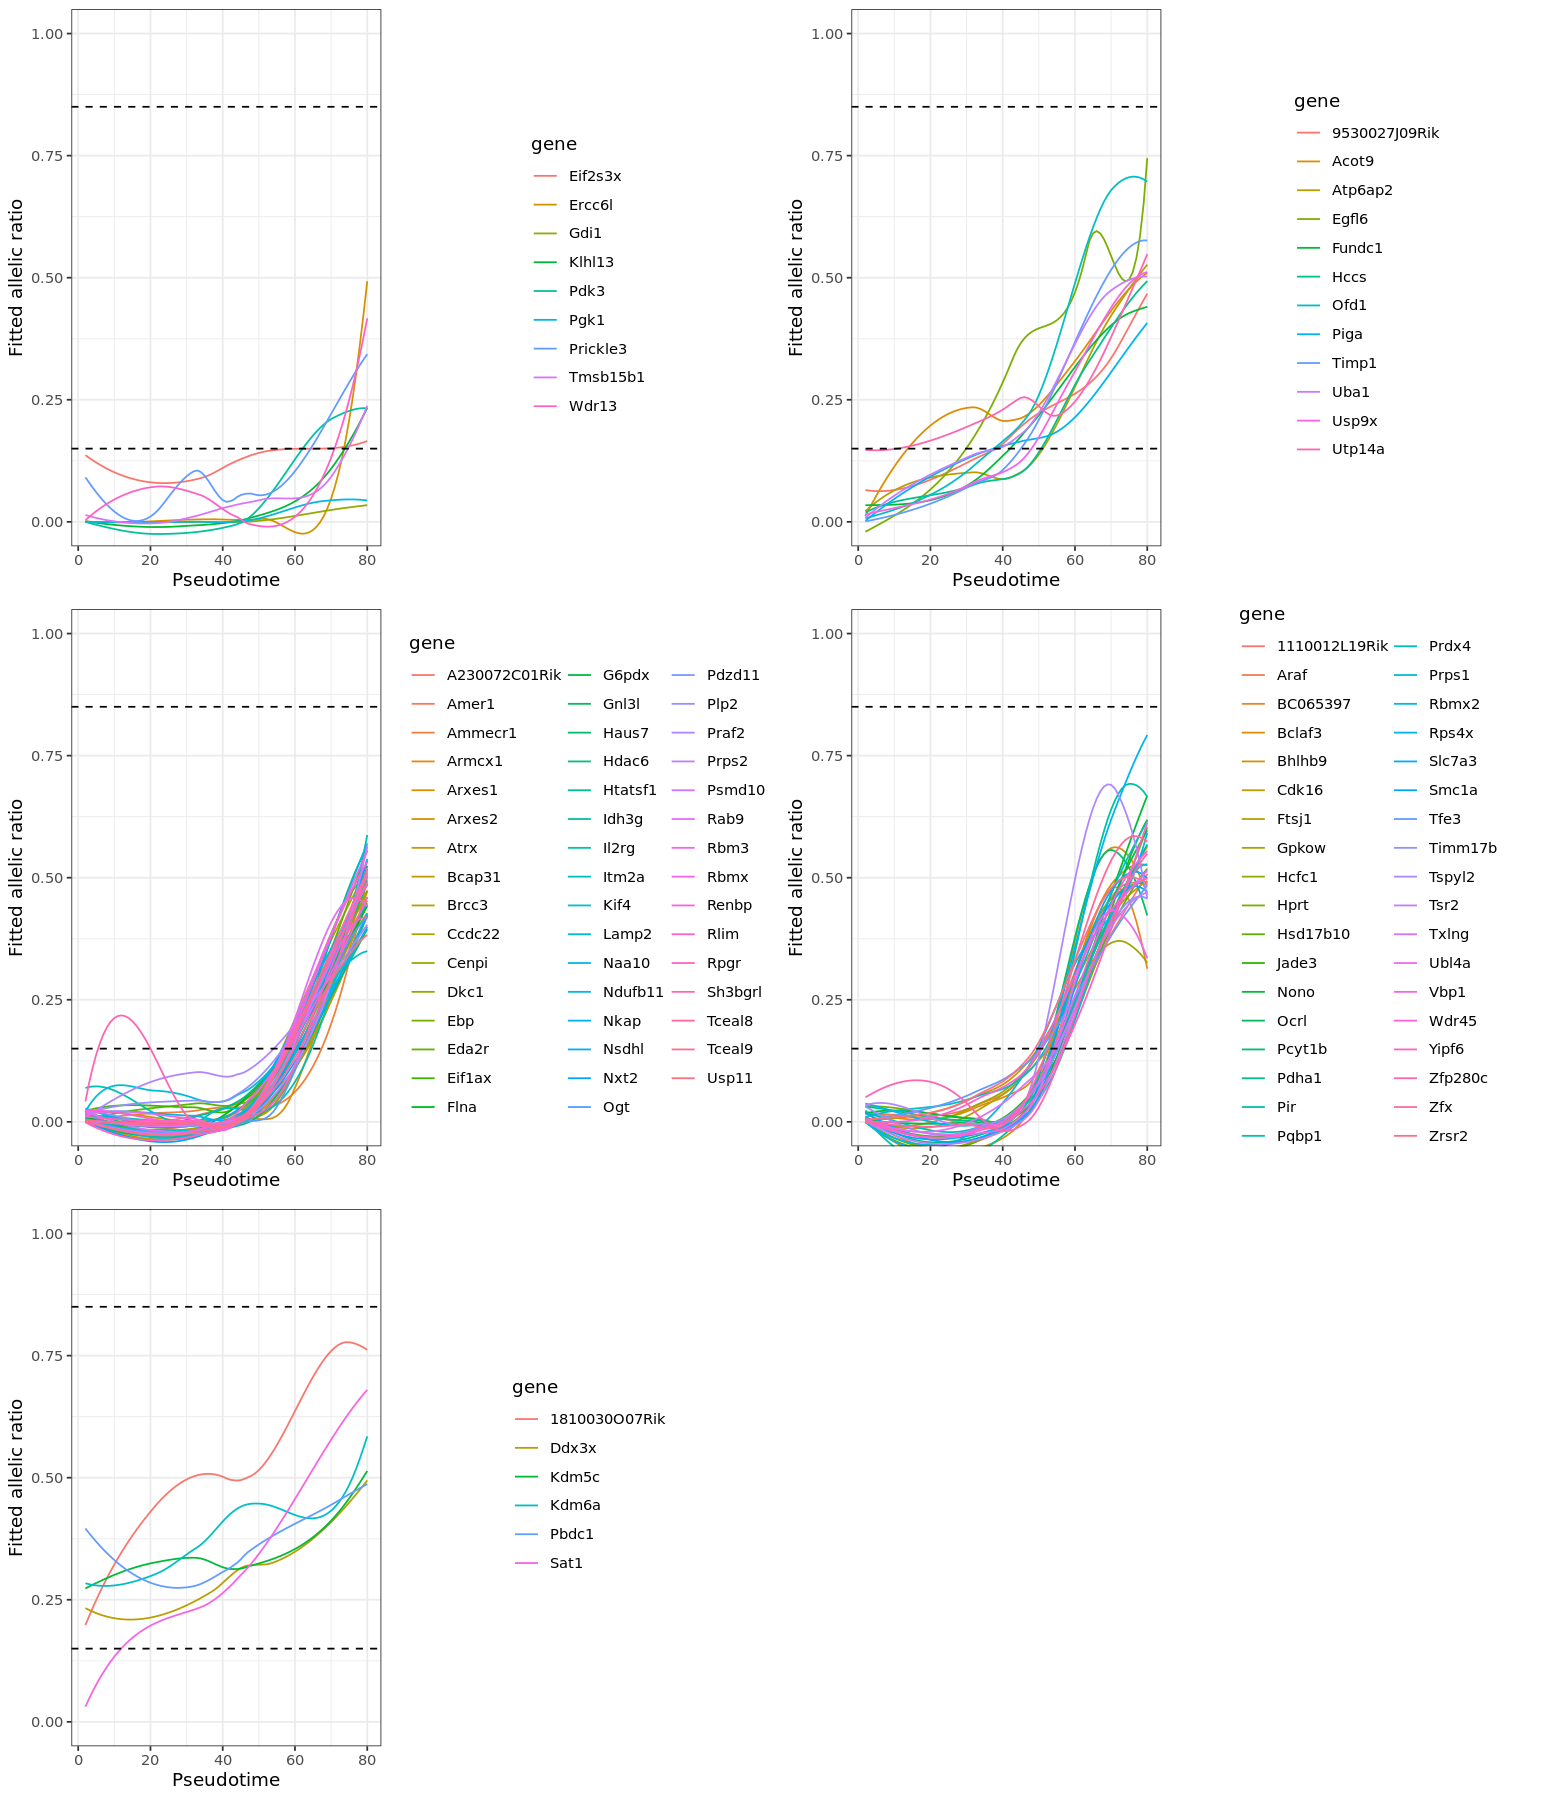

In [27]:
# Visualize clustered fitted models

kinetics_k_fit_plots <- list()

for (i in seq(unique(allelic_fit_kmeans_long$k_means_cluster))){
    
kinetics_k_fit_plots[[i]] <- allelic_fit_kmeans_long %>% filter(k_means_cluster == i) %>%
                            ggplot(aes(as.integer(pseudotime), fitted_data, group = gene, color = gene)) +
                                geom_line() +
                                geom_hline(yintercept = c(0.15, 0.85), linetype = 'dashed', size = .5) +
                                                                             coord_cartesian(ylim = c(0,1))+
                                ylab("Fitted allelic ratio")+
                                xlab("Pseudotime") +
                                theme_bw()
                                
    }

options(repr.plot.width=13, repr.plot.height=15)
CombinePlots(plots = kinetics_k_fit_plots, ncol=2)

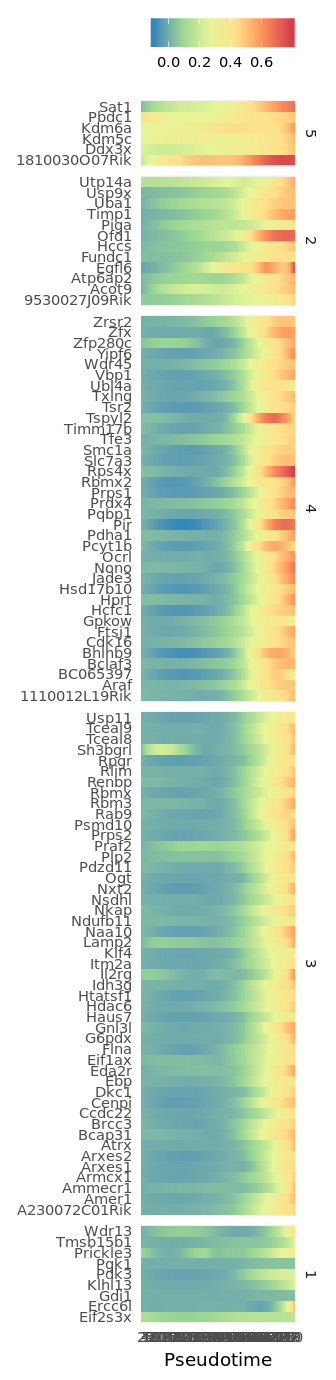

In [28]:
options(repr.plot.width=2.8, repr.plot.height=11.5)

allelic_fit_kmeans_long$pseudotime_fct <- factor(allelic_fit_kmeans_long$pseudotime, levels = sort(unique(as.integer(allelic_fit_kmeans_long$pseudotime))))
allelic_fit_kmeans_long$k_means_cluster <- factor(allelic_fit_kmeans_long$k_means_cluster, levels = c(5, 2, 4, 3, 1))

allelic_fit_heatmap <- allelic_fit_kmeans_long %>% 
            ggplot(aes(x = pseudotime_fct, y = gene, fill = fitted_data)) +
                geom_tile() +
                facet_grid(k_means_cluster ~ ., scales = 'free', space = 'free_y') +
                #facet_wrap(. ~ k_means_cluster, scales="free_y", ncol = 1, strip.position = "right") +
                scale_fill_distiller(palette = "Spectral") +
                labs(x="Pseudotime", fill = "") +
                
                theme_minimal()  +
                theme(legend.position = "top") +
                #theme(axis.text.y=element_blank()) +
                #theme(strip.background = element_blank(),
                #  strip.text.y = element_blank()) +
                #theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                theme(axis.title.y = element_blank()) 
               
allelic_fit_heatmap

In [35]:
pdf("allele_specific/XCR/allelic_fit_heatmap_MusCast_ratio.pdf", width=2.8, height=11.5)
plot(allelic_fit_heatmap)
dev.off()

png 
  2